# Valores No Asignados
En aplicaciones del mundo real, la mayoría de los dataset contendrán *missing values*¨(un feature sin valor válido). Esto puede deberse a múltiples causas, por ejemplo: una casa de 2 habitaciones, no contendrá información sobre una tercera habitación.

**Para afrontar este problema** (ya que los modelos arrojarán un error al intentar entrenarlos con data inválida), hay **3 aproximaciones**

1. **Eliminar columna con *missing values*:** es la manera más sencilla, pero potencialmente quita acceso a mucha información valiosa (a menos que la columna fuera casi por completo de valores inválidos)
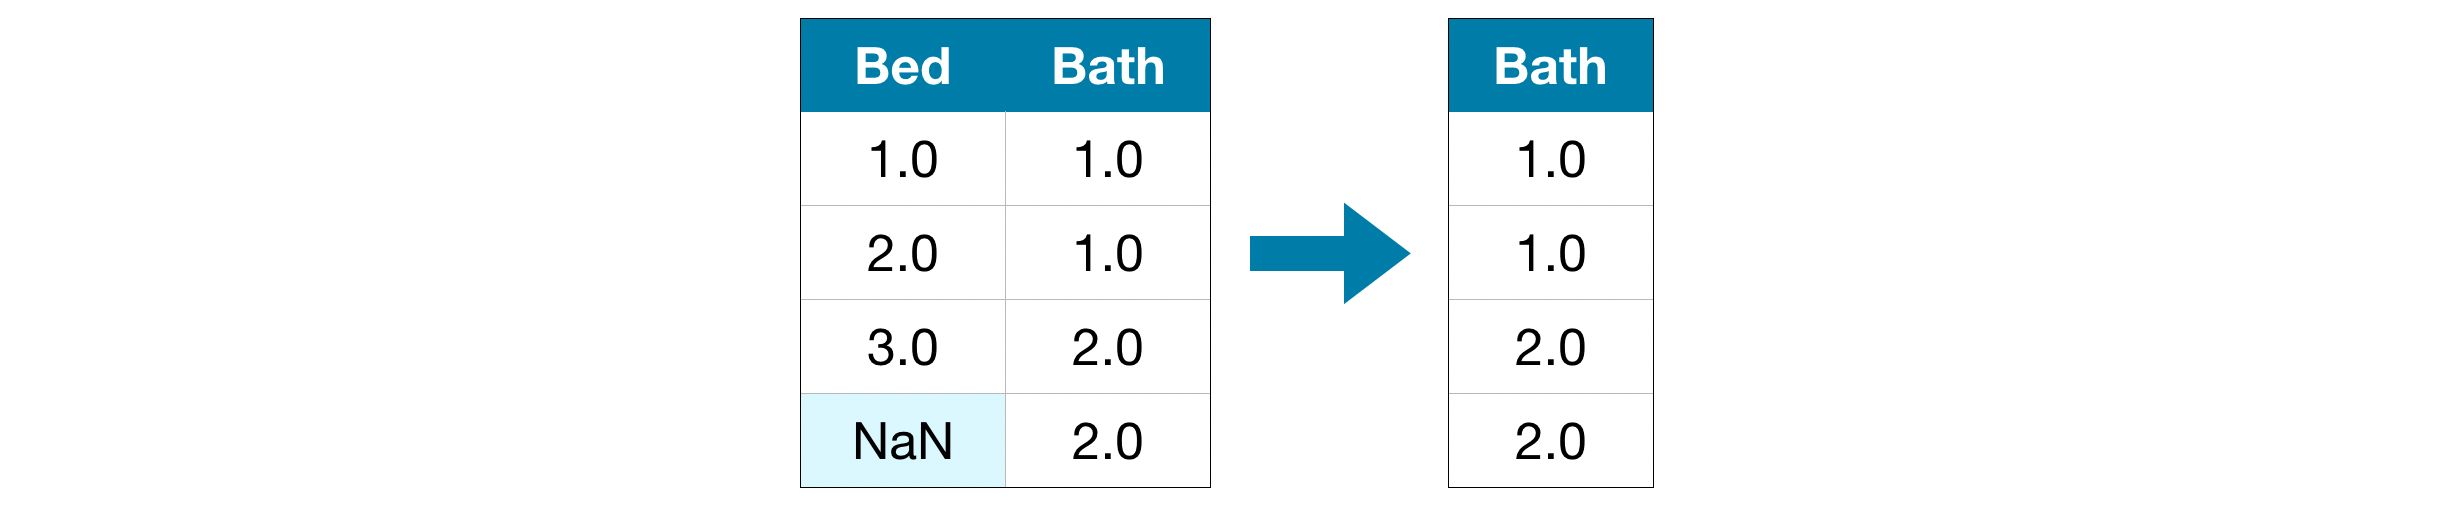

2. **Imputation:** colocar un valor en lugar del *missing*. Una posibilidad es colocar el valor medio de la columna, este no será exacto en muchos casos, pero aún así aumenta la efectividad respecto a eliminar la columna.
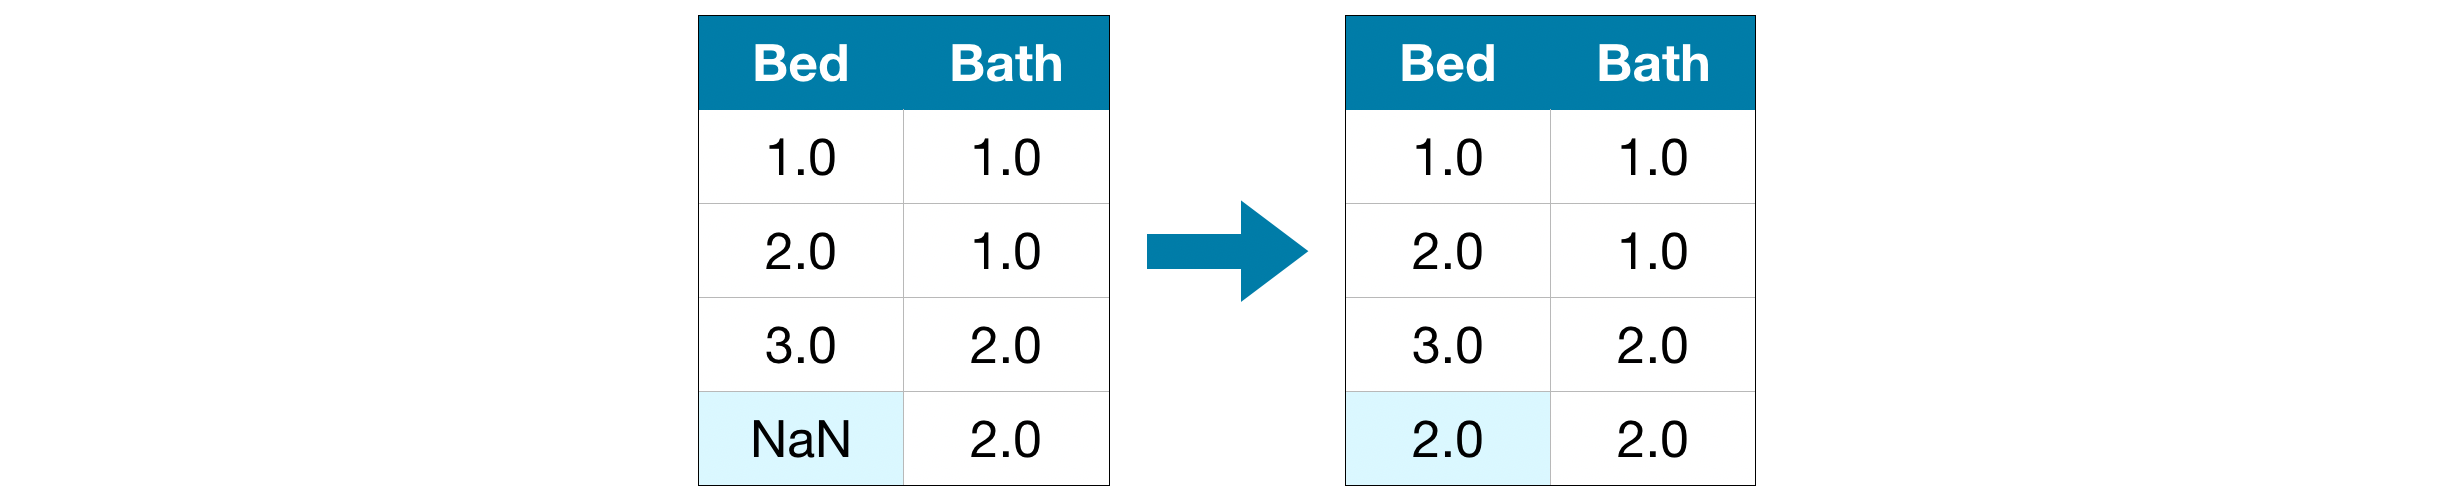

3. **Extensión de Imputation:** en general, la imputación va a funcionar bien, pero puede haber situaciones en las que el valor imputado sea sistemáticamente mayor o menor al real o que el valor perdido fuera especial por alguna razón. En este caso, puede mejorarse la técnica, agregando una columna que indique cuando los valores eran originalmente *missing*. 
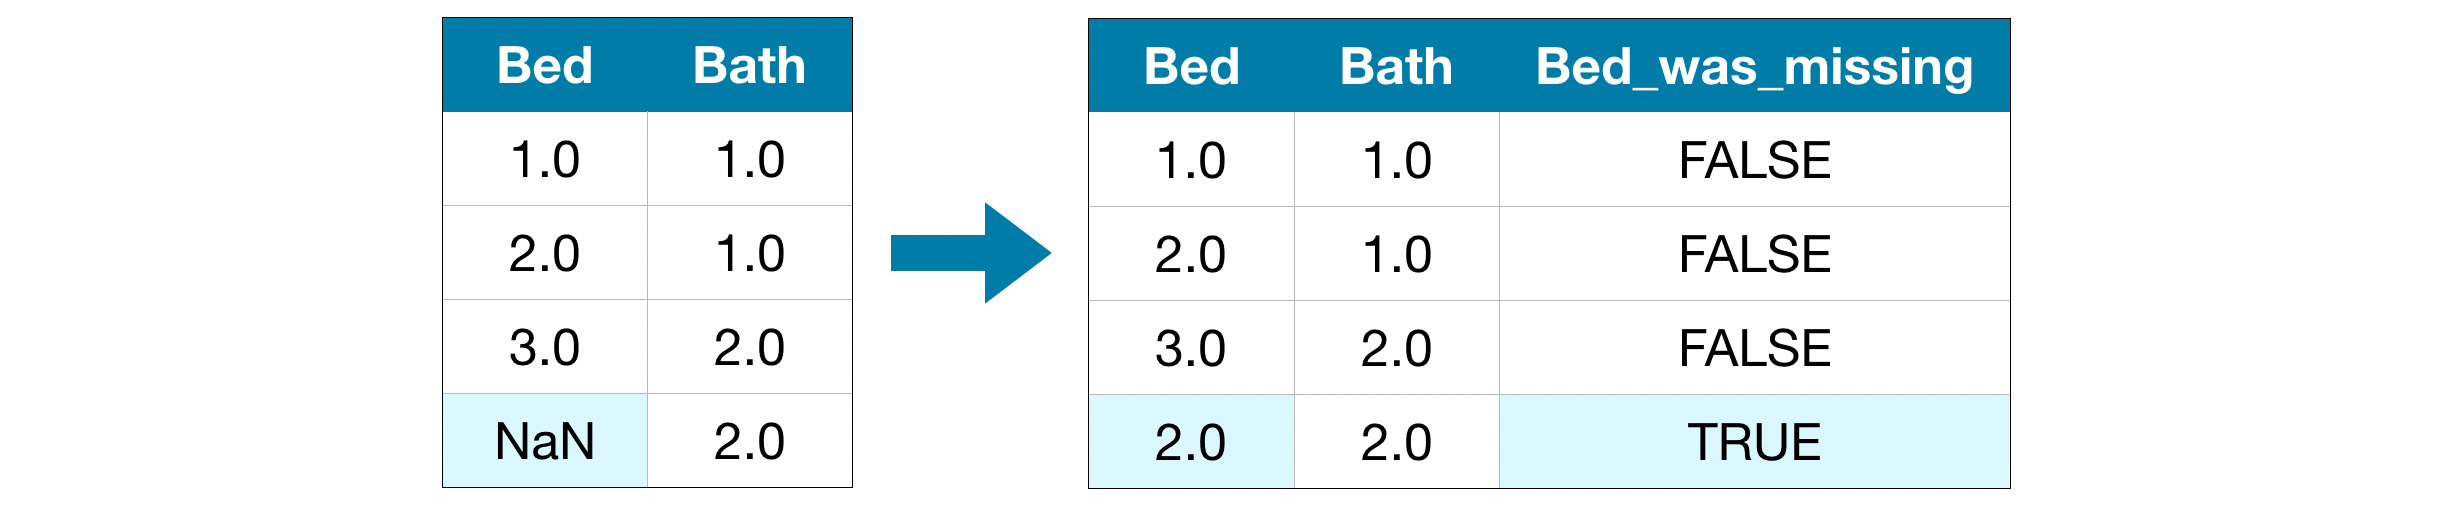

*OJO!* Esto puede mejorar notablemente los resultados o no influir en absoluto.

**NOTA:** no aclara cómo funciona esto en el modelo, asumo yo que "inteligentemente" trata a dichos valores de manera diferente, por ejemplo, ponderando su valor de alguna forma.

In [58]:
print('Iniciando...')
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('assets/input/train.csv', index_col='Id')
test_data = pd.read_csv('assets/input/test.csv', index_col='Id')

# NUEVA: dropea las filas con valor nulo en el target
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)

# target y X (features)
# para hacerlo facil remuevo todos los 'object' me quedo solo con features numericos
y = train_data.SalePrice
X = train_data.select_dtypes(exclude=['object'])
X.drop(['SalePrice'], axis=1, inplace=True)

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# features de la data de test (para submission)
test_X = test_data.select_dtypes(exclude=['object'])

print('Listo')

Iniciando...
Listo


**Ahora, antes de construir nuestro modelo, inspeccionamos los datos, en particular para ver cuantos *missing values* tiene.**

In [60]:
# train_X

In [61]:
# train_X.isnull() -> dataframe con True o False en cada valor (segun sea o no nulo)
# luego sum() -> suma los booleanos por columna (total de nulls por col)
missing_val_count_by_column = train_X.isnull().sum()

# IMPROTANTE! missing_val_count_by_column[missing_val_count_by_column > 0] 
# Es una forma de leer valores de una Serie (creo se veia en el de Pandas)
# missing_val_count...[(True, False, False,----)]
print(missing_val_count_by_column[missing_val_count_by_column > 0])

LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


Vemos, entonces, que las columnas *MasVnrArea* y *GarageYrBlt* poseen valores nulos pero en poca cantidad, por lo que si eliminamos por completo dichas columnas, nos exponemos a perder información de relevancia. Por otro lado, *LotFrontage* posee una mayor cantidad de valores nulos, aproximadamente, un 25% del total (igualmente seguiría perdiendo gran cantidad de información si eligiera eliminarla).

## Tratamiento de *missing values*
Antes que nada, para poder comparar la eficacia de cada método, defino una función que evalue el modelo obtenido:

In [62]:
def model_score(t_X, v_X, t_y, v_y):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(t_X, t_y)
    preds = model.predict(v_X)
    mae = mean_absolute_error(v_y, preds)
    return mae

1. Elimino las columnas

In [63]:
# IMPORTANTE! Formas de ver columnas con valores nulos
missing_values_columns_train = [col for col in train_X.columns if train_X[col].isnull().any()]
missing_values_columns_val = [col for col in train_X.columns if val_X[col].isnull().any()]

reduced_train_X = train_X.drop(missing_values_columns_train, axis=1)
reduced_val_X = val_X.drop(missing_values_columns_val, axis=1)

2. Imputación de valores

In [64]:
from sklearn.impute import SimpleImputer

# Por default rellena con 'average' pero hay otros metodos
# de relleno que pueden dar mejor o peor resultado
my_imputer = SimpleImputer()
imputed_train_X = pd.DataFrame(my_imputer.fit_transform(train_X))
imputed_val_X = pd.DataFrame(my_imputer.transform(val_X))

# IMPORTANTE: la imputacion remueve los nombres de las columnas
imputed_train_X.columns = train_X.columns
imputed_val_X.columns = val_X.columns

3. Extensión a la imputación

No se vio en la práctica como generar la extensión a *imputation* yo he visto en otros ejercicios cómo hacer para generar una nueva columna y agregarla (ahora no me acuerdo dónde, pero basicamente le ponias el nombre  + '_was_missing' y se conformaba con *isnull()* de la original), lo que no recuerdo es como se supone que le "avisabas" al modelo que debía interpretar dicha columna por la referencia a la que tenia los valores nulos.


### Comparo ambos métodos

In [65]:
drop_mae = model_score(reduced_train_X, reduced_val_X, train_y, val_y)
imputed_mae = model_score(imputed_train_X, imputed_val_X, train_y, val_y)

print('MAE (drop): {:.0f}'.format(drop_mae))
print('MAE (imputation): {:.0f}'.format(imputed_mae))

MAE (drop): 17838
MAE (imputation): 18063


### Primeras conclusiones
Podemos observar que, *en este caso**, el modelo obtenido mediante ***drop*** de las columnas con valores nulo obtuvo un **mejor resultado que** el que aplicaba ***imputation***.

**IMPORTANTE!**
Entonces, esto significaría que el método de imputación no sería un buen candidato para este dataset, o bien el valor imputado no es el que mejor se encaja con la realidad. Veamos esto un poco más, a priori, es muy dificil estipular qué tipo de valor conviene imputar (medio, mínimo, constante, etc), pero sí podríamos descartar valores que nos arrojarán malos resultados si tenemos en cuenta brevemente su implicancia, por ejemplo, en el caso de *GarageYrBlt* donde un valor nulo puede deberse a que la casa no posee garage, en ese caso, podemos saber que colocar un valor 0 nos va a dar un resultado muy errado, quizás, en cambio, podríamos porbar con el valor mínimo.

A continuación, estudio variantes de imputación:

In [66]:
cand_imputers = [
    SimpleImputer(strategy='median'),
    SimpleImputer(strategy='most_frequent'),
    SimpleImputer(strategy='constant', fill_value=0),
]

def training_imputation(imputer):
    imp_train_X = pd.DataFrame(imputer.fit_transform(train_X))
    imp_val_X = pd.DataFrame(imputer.transform(val_X))

    # IMPORTANTE: la imputacion remueve los nombres de las columnas
    imp_train_X.columns = train_X.columns
    imp_val_X.columns = val_X.columns
    return (imp_train_X, imp_val_X)

for i in range(len(cand_imputers)):
    # genero la imputacion en train y validation datasets
    imputed_train_X, imputed_val_X = training_imputation(cand_imputers[i])
    
    imp_mae = model_score(imputed_train_X, imputed_val_X, train_y, val_y)
    print('Imputer {} MAE: {:.0f}'.format(i+1, imp_mae))

Imputer 1 MAE: 17792
Imputer 2 MAE: 17956
Imputer 3 MAE: 18018


Analizando resultados anteriores, vemos que **el mejor imputer para este caso fue colocando el valor "mediana"**. Además, constatamos que colocar un valor 0 arroja malos resultados (por lo indicado en el análisis de GarageYrBlt).

Una variante que había probado es la de imputar ciertos valores y dropear otros, sobre todo teniendo en cuenta que inicialmente vimos que, en este caso, dropear las columnas con valores nulos no daba un mal resultado. Dejo, a continuación, la forma en que se resolvería:

In [67]:
# primero imputo el valor 'mediana'
best_imputer = cand_imputers[0]
imputed_train_X, imputed_val_X = imputation(imputer=best_imputer)

# luego, dropeo la columna deseada 'lotFrontage' (es la q mas nulls tiene)
imputed_train_X.drop(['LotFrontage'], axis=1, inplace=True)
imputed_val_X.drop(['LotFrontage'], axis=1, inplace=True)

imp_drop_mae = model_score(imputed_train_X, imputed_val_X, train_y, val_y)
print('Imputer + Drop MAE: {:.0f}'.format(imp_drop_mae))

Imputer + Drop MAE: 18065


Observo que los resultados **empeoran, así que descartaría esta opción** (en una práctica habia notado mejora, usando valor 'mean' en la imputación).

Finalmente, **la última opción que se me había ocurrido es la de imputar diferentes tipos de valores, según la "feature"**, por ejemplo, valor mínimo en una y promedio en otra. **Lo dejo para analizar más adelante** como debería hacerse ese caso, ya que el uso del Imputer visto hasta ahora afecta a todos por igual, por tanto si quisiera lograr lo dicho antes, debería quitar la columna que quiero imputar diferente, tratarla manualmente y luego volver a incorporar dicha columna.

## Modelo final - Competencia
Habiendo analizado diferentes imputaciones y seleccionado la mejor, entreno el modelo sobre los datos completos (train + validation), realizo las predicciones sobre *test* y subo los resultados a la [Hose Pricing Competition](https://www.kaggle.com/c/home-data-for-ml-course)

In [81]:
# Imputo X total (train + validation)
final_imputed_X = pd.DataFrame(best_imputer.fit_transform(X))
final_imputed_X.columns = X.columns

# Imputo test_X (de la competencia y subir resultado)
final_test_X = pd.DataFrame(best_imputer.fit_transform(test_X))
final_test_X.columns = test_X.columns
# final_test_X.index = test_X.index

# Entreno modelo con dataset de entrenamiento total (train + valid)
# Realizo prediccion sobre la data de test (imputada previamente)
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(final_imputed_X, y)
predictions = model.predict(final_test_X)

In [86]:
# IMPORTANTE! 
# Al realizar las imputaciones se pierde también el index
# Por eso, aqui uso test_X.index (y no final_test_X)
# También, podría hacer final_test_X.index = test_X.index

output = pd.DataFrame({'Id': test_X.index, 'SalePrice': predictions})
output.to_csv('assets/output/home_submission_imputation.csv', index=False)

In [85]:
# output

Id  SalePrice
0     1461  127507.00
1     1462  157620.00
2     1463  178336.74
3     1464  180924.85
4     1465  200462.25
...    ...        ...
1454  2915   80785.00
1455  2916   85049.71
1456  2917  160168.61
1457  2918  110361.08
1458  2919  234733.20

[1459 rows x 2 columns]